In [52]:
# Install the fastbook package quietly and upgrade it to the latest version if needed
%pip install -Uqq fastbook

Note: you may need to restart the kernel to use updated packages.


In [72]:
#Import all necessary imports

import fastbook
from fastbook import *
from fastai.vision.all import *
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


**Specifying the Dataset Path**

Before proceeding with data loading and preprocessing, we need to specify the location of our dataset. In this case, we're using a dataset named 'big-cats', which we have stored in Google Drive. We achieve this by defining a `Path` object from the `pathlib` library.

- **Why `Path` from `pathlib`?**: The `pathlib` library provides a simple hierarchy of classes to handle filesystem paths. It's an object-oriented approach to file system paths and is preferred over traditional string-based paths since it provides more flexibility and intuitive methods to handle file paths.
- **Dataset Path**: The path `"/content/drive/MyDrive/datasets/big-cats"` points to the location of our dataset in Google Drive. This is particularly common when working in environments like Google Colab, where Google Drive is used to store and access datasets.

In [54]:
# Define the path to the dataset
# 'Path' is used from the pathlib library to handle filesystem paths
# Here, we specify the path to the 'big-cats' dataset located in Google Drive (since we are working in Google Cloab)
path = Path("datasets/big-cats")

**Creating a DataBlock for Image Classification**

In this step, we define a `DataBlock` for our image classification task. Fastai's `DataBlock` API provides a flexible and powerful way to create a dataset ready for training. The key components of our `DataBlock` are:

- **Data Types with `blocks`**: We use `ImageBlock` for the input images and `CategoryBlock` for the output labels, indicating we're dealing with an image classification task.
- **Data Retrieval with `get_items`**: `get_image_files` is a function that retrieves all the image files from the given path.
- **Data Splitting with `splitter`**: We use `RandomSplitter` to randomly split the dataset into training and validation sets, allocating 20% of the data for validation purposes. The `seed` is set to ensure reproducibility.
- **Labeling with `get_y`**: The `parent_label` function extracts labels from the parent directory's name, which is a common way to label images based on folder names.
- **Transformations**:
  - **Item-level Transform (`item_tfms`)**: We resize all images to 460 pixels. This is an initial transformation before batching.
  - **Batch-level Transform (`batch_tfms`)**: We apply data augmentation techniques (like random cropping, flipping, etc.) and resize images to 224 pixels, which is a common size for models like ResNet.

By setting up this `DataBlock`, we are creating a pipeline that handles data loading, splitting, preprocessing, and augmentation, all crucial steps for preparing our data for model training.

In [55]:


# Define the DataBlock for our dataset
cats = DataBlock(
    # Define the type of data: ImageBlock for input and CategoryBlock for output (labels)
    blocks=(ImageBlock, CategoryBlock),

    # Function to get the list of image files from 'path'
    get_items=get_image_files,

    # RandomSplitter to split the data into training and validation sets
    # 'valid_pct=0.2' means 20% of the data will be used for validation
    # 'seed=42' ensures reproducibility of the split
    splitter=RandomSplitter(valid_pct=0.2, seed=42),

    # Function to extract labels from the parent folder's name
    get_y=parent_label,

    # Transformation: Resize the images to 460 pixels for pre-processing
    item_tfms=Resize(460),

    # Batch-level transformations: Apply augmentation and resize images to 224 for training
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)



**Initializing DataLoaders from the DataBlock**

After defining our `DataBlock`, the next step is to transform it into `DataLoaders`. A `DataLoaders` object in Fastai is a container for your training and validation dataloaders. It's responsible for providing batches of data to the model during training and validation phases. We create the `DataLoaders` using the path to our dataset:

- **Creating `DataLoaders`**: By calling the `dataloaders` method on our `DataBlock` (named `cats`), and passing the `path` to our dataset, we initialize the `DataLoaders`. This method automatically applies the transformations, data splitting, and batching as defined in the `DataBlock`.

- **Path to Dataset**: The `path` variable we defined earlier points to the location of our 'big-cats' dataset. It's crucial for the `DataBlock` to know where to fetch the data from.

This step is pivotal as it finalizes the data preparation process, making our dataset ready for feeding into a neural network for training and validation.

In [56]:
# Creating DataLoaders from the DataBlock
# 'dls' stands for DataLoaders, which is a Fastai object that holds training and validation data loaders
dls = cats.dataloaders(path)

c:\Users\ekici\OneDrive\Desktop\bigdata-project\venv\lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


**Visualizing the Data: Training and Validation Batches**

An essential step in any data science or machine learning project is to visually inspect the data. This not only helps in understanding the data better but also ensures that our data pipeline (including augmentations and transformations) is working as expected. Here, we visualize a batch of images from both our training and validation sets:

1. **Training Batch Visualization**: By calling `show_batch` on `dls.train`, we can see a batch of images from our training dataset. This gives us an insight into the data augmentations and transformations that have been applied. We set `max_n=4` to display four images, and `nrows=1` to arrange them in a single row.

2. **Validation Batch Visualization**: Similarly, `show_batch` on `dls.valid` lets us observe a batch from our validation dataset. It's crucial to compare this with the training batch to ensure consistency in data representation between the two sets.

These visualizations act as a sanity check and provide a quick glimpse into the variety and nature of the images that the model will be trained on.

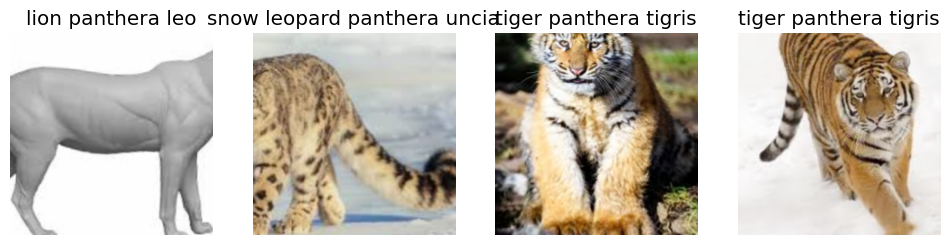

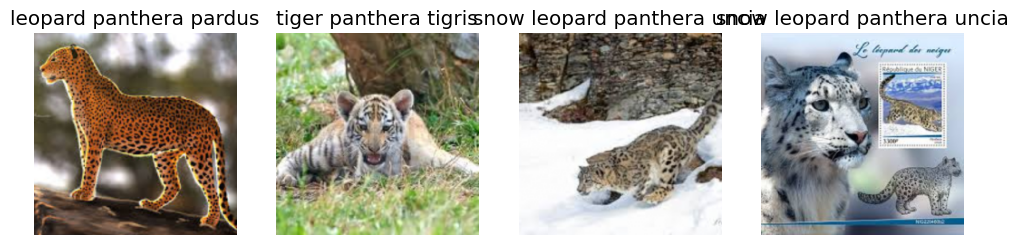

In [57]:
# Display a batch of images from the training set
dls.train.show_batch(max_n=4, nrows=1)

# Display a batch of images from the validation set
dls.valid.show_batch(max_n=4, nrows=1)

**Building the Model with Fastai**

After preparing our data, the next crucial step is to define the model that will be trained on this data. For this, we use Fastai's `vision_learner` function, which simplifies the process of creating a convolutional neural network (CNN) for image classification tasks.

- **Learner Creation with `vision_learner`**: This function is a high-level API provided by Fastai to quickly instantiate a learner object. The learner includes not just the model but also the data, loss function, optimizer, and more, encapsulating everything needed for training.

- **Model Architecture**: We choose `resnet34` as our base architecture. ResNet34 is a well-known CNN architecture that is pre-trained on ImageNet. Using a pre-trained model allows us to leverage transfer learning, where the model brings in knowledge learned from a large dataset and applies it to our specific task.

- **Metrics**: We specify `error_rate` as our metric. Error rate is a common metric in classification tasks, representing the proportion of incorrect predictions.

By defining `model` using `vision_learner`, we have set up a powerful CNN that is ready to be trained on our 'big-cats' dataset. This step is pivotal as it bridges the gap between our prepared data and the upcoming training phase.

In [58]:
# Creating a model using Fastai's vision_learner
# 'vision_learner' is a convenient function to create a CNN learner with a specified architecture
model = vision_learner(dls, resnet34, metrics=error_rate)


In [59]:
# Fine-tuning the model
# 'fine_tune' is a Fastai method to train a model that is already pre-trained on a different dataset
# In this case, we fine-tune the model for 4 epochs
model.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.586971,0.485387,0.180556,01:29


epoch,train_loss,valid_loss,error_rate,time
0,0.545714,0.384953,0.118056,01:56
1,0.436243,0.335732,0.097222,01:55
2,0.343866,0.295867,0.086806,01:56
3,0.272055,0.304035,0.086806,01:56


epoch,train_loss,valid_loss,error_rate,time
0,0.145673,0.300763,0.086806,01:57
1,0.152679,0.297463,0.083333,01:56
2,0.134837,0.300049,0.083333,01:57
3,0.128550,0.303202,0.076389,01:57
4,0.115814,0.298380,0.076389,01:56
5,0.109584,0.299808,0.079861,01:57


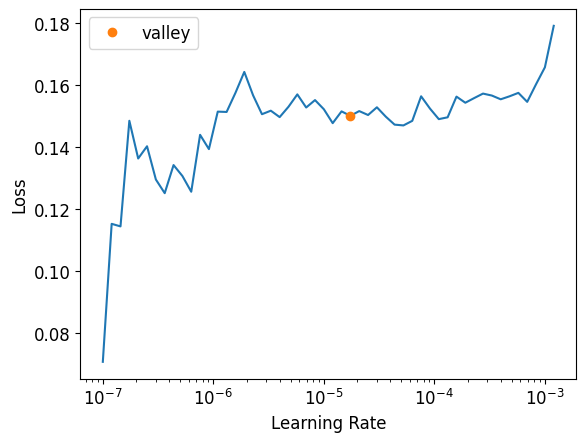

In [60]:
# Unfreeze the model for further training
model.unfreeze()

# 'lr_find' helps in identifying a good learning rate for training the model
lr_suggestion = model.lr_find()
# Fit the model using the 'fit_one_cycle' method

# This method uses the 1cycle policy for learning rate management
# We train for 6 more epochs with a learning rate ranging from 1e-6 to 1e-4
model.fit_one_cycle(6, lr_max=slice(1e-6,1e-4))

# Learning Rate vs. Loss Graph Interpretation

The graph above represents a typical learning rate finder plot. It is used to find the optimal learning rate for training a machine learning model. The x-axis shows the learning rate on a logarithmic scale, and the y-axis shows the loss.

Here's how to interpret the graph:

- **Initial Sharp Decrease in Loss:** When the learning rate is too low (towards the left side of the graph), the loss decreases sharply. This indicates that the model is learning, but very slowly. Such low learning rates are not efficient for training as they would take a very long time to converge.

- **Valley (Optimal Learning Rate Range):** As the learning rate increases, the loss reaches a minimum point, creating a 'valley' in the graph. The point marked 'valley' suggests an optimal learning rate. This is typically the range you would want to choose for training your model. It is low enough to allow the model to converge smoothly but high enough to ensure a faster training process than the very low learning rates.

- **Increase in Loss (Learning Rate Too High):** Beyond the valley, the loss starts to increase again. This indicates that the learning rate has become too high. At such high learning rates, the model's weights update too drastically, causing it to overshoot the optimal points in the loss landscape, which leads to an increase in loss.

In summary, the goal is to select a learning rate in the region of the lowest stable loss before the graph starts to ascend. This is typically a bit lower than the lowest point to allow for some margin of error during training.

**Exporting the Trained Model**

After training and fine-tuning our model to a satisfactory level, the next crucial step is to export it for future use. This could be for deployment in an application, further evaluation, or simply to save our progress. In Fastai, exporting a model is a straightforward process:

- **Export Method**: We use the `model.export` method to save our trained model. This method bundles everything we need to deploy our model (including the architecture, weights, and some metadata) into a single file.

- **File Format**: The model is saved in a Pickle file (`.pkl`). Pickle is a Python-specific binary serialization format, which is efficient for storing Python objects. In this case, it helps in storing our model.

- **File Naming and Path**: We name the file `fastai_model.pkl` and save it in a `models` directory. It’s important to choose a descriptive name and an organized file structure, especially when working with multiple models or versions.

By exporting the model, we ensure that all the effort put into training and tuning is preserved. We can load this model at any time in the future to make predictions, continue training, or analyze its performance further.

In [61]:
# Export the trained model
# The model is saved in a Pickle file (.pkl) for later use or deployment
model.export('models/fastai_model.pkl')

### FastAI ROC_AUC Curve


**Analyzing Model Performance with ROC Curves**

To further evaluate our model's performance, especially in distinguishing between different classes, we utilize the Receiver Operating Characteristic (ROC) curves and the Area Under the Curve (AUC). ROC curves are a powerful tool to assess the performance of a classifier in a multi-class setting.

1. **ROC Curve and AUC**: The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The AUC provides a single number summary of the ROC curve, representing the model's ability to distinguish between classes.

2. **Preparing for ROC Analysis**: We start by obtaining the predictions from our model and one-hot encoding our targets. This prepares our data for ROC analysis.

3. **Calculating ROC and AUC for Each Class**: We calculate the ROC curve and AUC for each class individually, which allows us to see how well the model performs for each specific class.

4. **Visualization**: We plot the ROC curves for each class, using different colors for clarity. The diagonal dashed line represents a random classifier; a good model's ROC curve will be far above this line.

This analysis helps us understand not just the overall performance of our model, but also how it performs on each individual class, which is crucial in multi-class classification problems.

c:\Users\ekici\OneDrive\Desktop\bigdata-project\venv\lib\site-packages\fastai\torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


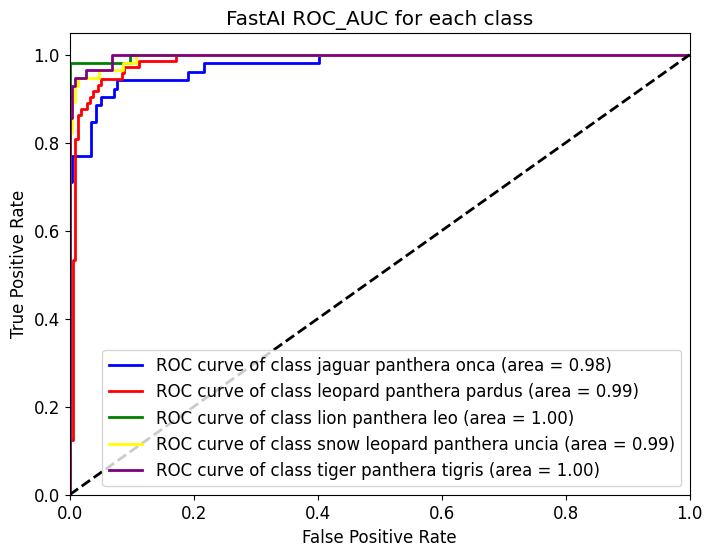

In [62]:
# Getting predictions and true labels from the learner
# 'preds' are the predicted probabilities for each class
# 'targets' are the true class labels
preds, targets = model.get_preds()

# Number of classes in the dataset
# 'dls.vocab' contains the list of all classes
n_classes = len(dls.vocab)

# One-hot encode the targets
# This is necessary for multi-class ROC analysis
# Each column of 'targets_one_hot' corresponds to a class
targets_one_hot = label_binarize(targets, classes=range(n_classes))

# Dictionaries to store the false positive rates and true positive rates for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculating ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(targets_one_hot[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curves
plt.figure(figsize=(8, 6))
# Using a color cycle for different classes
colors = cycle(['blue', 'red', 'green', 'yellow', 'purple', 'orange', 'black'])

# Iterating over each class to plot its ROC curve
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {dls.vocab[i]} (area = {roc_auc[i]:0.2f})')

# Plotting the diagonal line representing random chance
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Setting limits for X and Y axis
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Adding labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('FastAI ROC_AUC for each class')

# Adding a legend
plt.legend(loc="lower right")

# Displaying the plot
plt.show()

## Comparing FastAI to Teachable Machine

### FastAI Confusion Matrix, Model Accuracy and Model Loss Graphs

**Interpreting the Model: Confusion Matrix**

To gain insights into our model's performance and understand where it's making correct and incorrect predictions, we use Fastai's `ClassificationInterpretation` class. This class provides various methods for model interpretation, one of the most informative being the confusion matrix.

- **Creating an Interpreter**: We instantiate an interpreter for our model using `ClassificationInterpretation.from_learner`. This object allows us to analyze the results of our model on the validation set.

- **Plotting the Confusion Matrix**: The confusion matrix is a vital tool in classification tasks. It shows us the number of times each class was predicted versus the actual classes. By calling `interp.plot_confusion_matrix`, we generate a visual representation of this matrix. The parameters `figsize=(12,12)` and `dpi=60` are used to specify the size and resolution of the plot, making it more readable.

- **Benefits of the Confusion Matrix**: The matrix helps us identify which classes are being confused with each other. This can guide us in further improving the model, be it through additional training, tweaking the model architecture, or gathering more data for underperforming classes.

The confusion matrix thus serves as a crucial tool in our model evaluation process, providing clear, actionable insights into the model's performance.

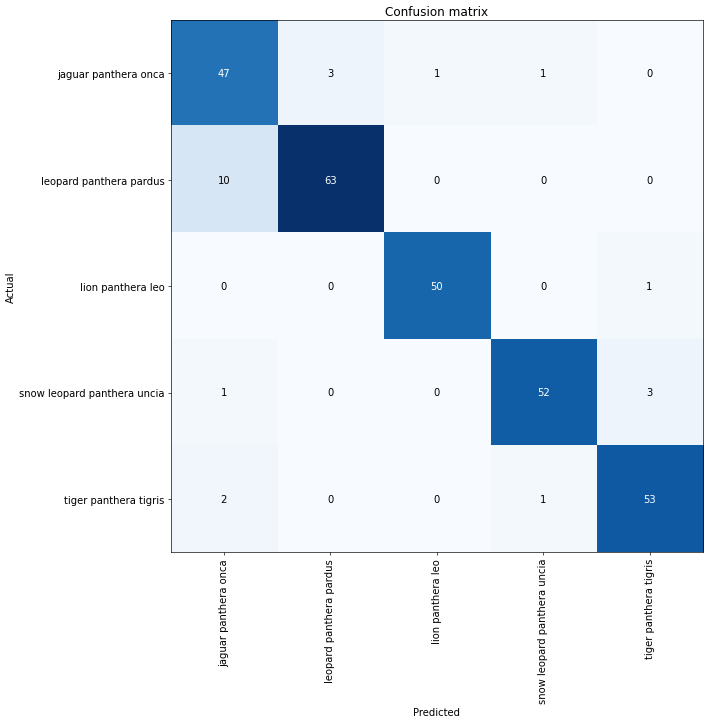

In [85]:
# Plotting the training and validation loss
model.recorder.plot_loss()
# Interpretation for classification
interp = ClassificationInterpretation.from_learner(model)

# Plot confusion matrix
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

### Teachable Machine Confusion Matrix, Model Accuracy and Model Loss Graphs


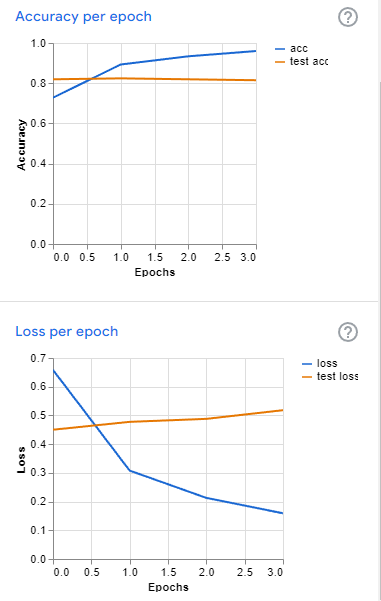
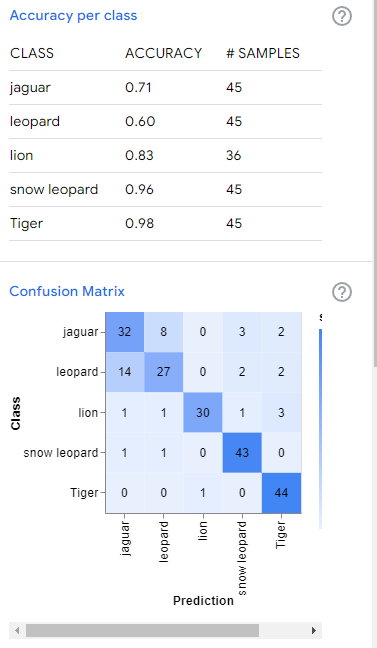

## Keras Model

**Setting Up a Keras Model for Image Classification**

In this section, we transition from Fastai to Keras, another powerful deep learning library, to build and train a similar model. This allows us to compare the two approaches. Our steps are as follows:

1. **Data Preparation**: We use `ImageDataGenerator` from Keras for data loading and augmentation. Two generators are set up: one for training (with data augmentation like rotation, shifting, and flipping) and one for validation (with only rescaling).

2. **Creating the Model**:
   - We choose ResNet50, a well-known CNN architecture, as our base model. It comes pre-trained on ImageNet, allowing us to utilize transfer learning.
   - We add custom layers (including a global average pooling layer and dense layers) on top of ResNet50 to tailor the model to our dataset.
   - The final output layer has `n_classes` units, corresponding to the number of classes in our dataset, with a softmax activation function.

3. **Model Compilation**: The model is compiled using the Adam optimizer and categorical crossentropy loss function, which are standard choices for multi-class classification tasks.

By setting up this Keras model, we aim to replicate the experiment conducted with Fastai and observe any differences in ease of use, training process, and performance.

In [64]:
# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.2
)

# Data augmentation configuration for validation data
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
    
)

# Load data and prepare it for training
train_generator = train_datagen.flow_from_directory(
    'datasets/big-cats',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    shuffle=False
)

# Load data and prepare it for validation
validation_generator = validation_datagen.flow_from_directory(
    'datasets/big-cats',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

# Manually compute the class weights
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

Found 1152 images belonging to 5 classes.
Found 288 images belonging to 5 classes.


In [65]:

class_weights = {i: weights[i] for i in range(len(weights))}

# Initialize the ResNet50 model with pre-trained ImageNet weights
base_model = ResNet50V2(weights='imagenet', include_top=False)
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Define the model
keras_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
keras_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**Training the Keras Model**

With our Keras model set up and compiled, the next crucial phase is training. Training is where the model learns from the data, adjusting its weights to minimize the loss function and improve its ability to classify images accurately.

- **Model Fitting**: We use the `fit` method to train the model. This method takes both training and validation data, allowing the model to learn from the training data and validate its learning on data it hasn't seen during training.

- **Epochs**: We train the model for 10 epochs. An epoch is a complete pass through the entire training dataset. The number of epochs is a hyperparameter that can be adjusted based on the model's performance.

- **Steps per Epoch**: We calculate `steps_per_epoch` and `validation_steps` based on the size of our training and validation datasets, respectively. This ensures that the model sees all the training and validation data in each epoch.

- **Validation During Training**: By providing validation data, we can monitor the model's performance on a separate dataset that it hasn't trained on. This helps in detecting overfitting early on.

Training is a critical step in the machine learning pipeline, where the model gets to 'learn' from the data. The history of this training process, captured in the `history` object, will be instrumental in evaluating the model's performance and making further improvements.

In [66]:
# Train the model
history = keras_model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    class_weight=class_weights
)

Epoch 1/10
36/36 [==============================] - 32s 820ms/step - loss: 3.5691 - accuracy: 0.5477 - val_loss: 0.8235 - val_accuracy: 0.7326
Epoch 2/10
36/36 [==============================] - 30s 821ms/step - loss: 0.7447 - accuracy: 0.6632 - val_loss: 0.4153 - val_accuracy: 0.8403
Epoch 3/10
36/36 [==============================] - 29s 807ms/step - loss: 0.4689 - accuracy: 0.7639 - val_loss: 0.3631 - val_accuracy: 0.8542
Epoch 4/10
36/36 [==============================] - 29s 794ms/step - loss: 0.3691 - accuracy: 0.8455 - val_loss: 0.3750 - val_accuracy: 0.8403
Epoch 5/10
36/36 [==============================] - 30s 820ms/step - loss: 0.3334 - accuracy: 0.8655 - val_loss: 0.4379 - val_accuracy: 0.8160
Epoch 6/10
36/36 [==============================] - 29s 797ms/step - loss: 0.3741 - accuracy: 0.8429 - val_loss: 0.3146 - val_accuracy: 0.8924
Epoch 7/10
36/36 [==============================] - 29s 801ms/step - loss: 0.3064 - accuracy: 0.8542 - val_loss: 0.3663 - val_accuracy: 0.8472

INFO:tensorflow:Assets written to: models/keras_model.pkl\assets


### Keras Confusion Matrix, Model Accuracy and Model Loss Graphs

**Visualizing Training Progress: Accuracy and Loss**

After training our Keras model, it's important to visualize its performance over time. This helps us understand how well the model is learning and if there are any issues like overfitting or underfitting. We focus on two key aspects: accuracy and loss.

- **Accuracy Plot**: The first subplot displays the training and validation accuracy over each epoch. Higher accuracy indicates better performance. By comparing the training and validation accuracies, we can assess how well the model is generalizing to unseen data.

- **Loss Plot**: The second subplot shows the training and validation loss. Loss is a measure of how well the model is doing in terms of the error it's making in predictions. A lower loss is better, and a large gap between training and validation loss might indicate overfitting.



These visualizations are key tools in the model evaluation process, providing clear and immediate feedback on the training process and guiding further model tuning and experimentation.

9/9 [==============================] - 6s 575ms/step


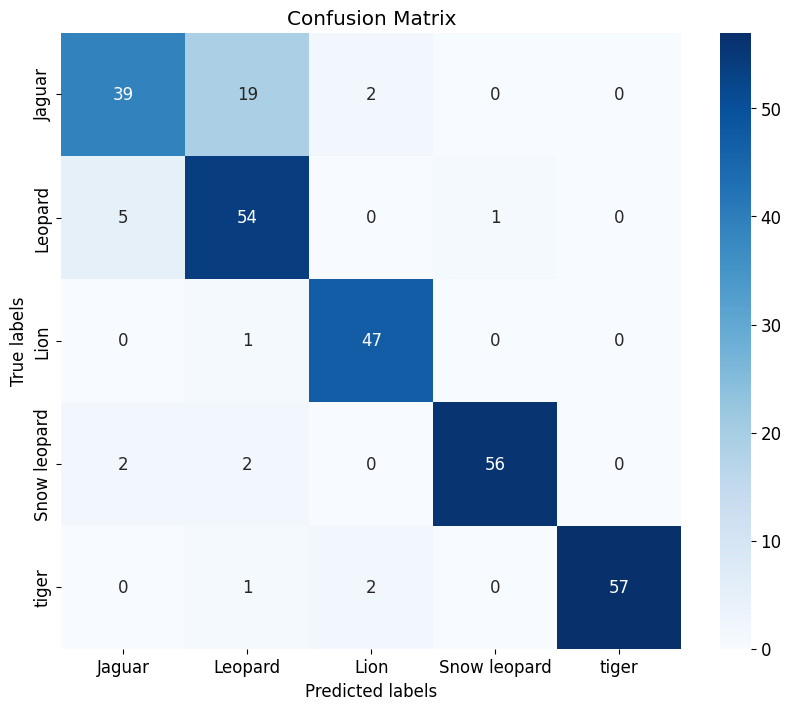

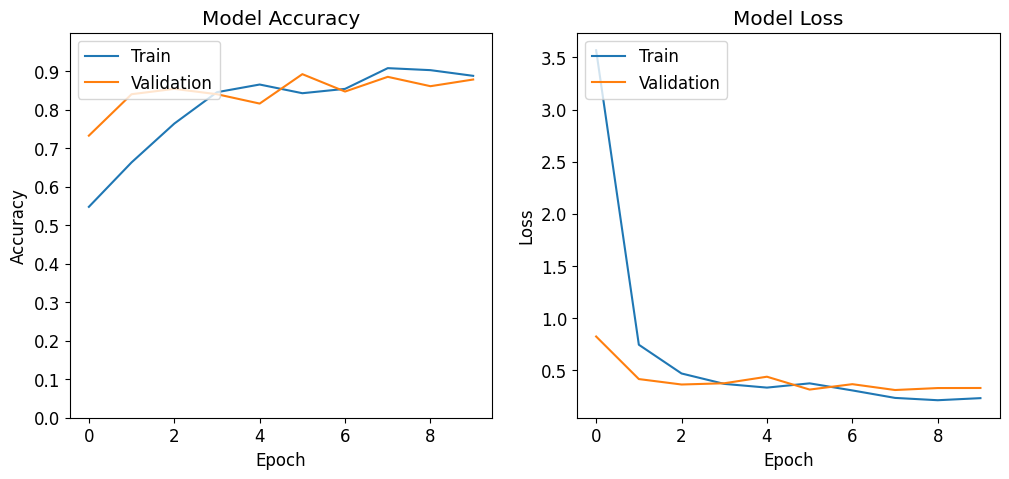

In [67]:
# Predict the data (classification results)
validation_generator.reset()
predictions = keras_model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
predicted_classes = np.argmax(predictions, axis=1)
class_labels = ["Jaguar","Leopard","Lion","Snow leopard","tiger"]
# True labels
true_classes = validation_generator.classes

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Accuracy and Loss Plots
plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim([0, 1])  # Set y-axis limits to [0, 1] if your accuracy ranges from 0 to 100%

# Adjust y-ticks to show more labels if needed
y_ticks = np.arange(0, 1, 0.1)  # Adjust the step to a suitable value for your data
plt.yticks(y_ticks)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Keras Model ROC_AUC Curve Per Class

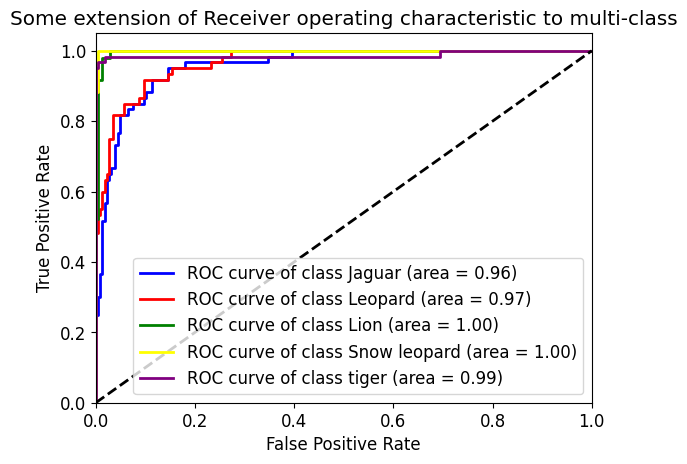

In [68]:
n_classes = len(class_labels)
# Binarize the labels for ROC curve
y_bin = label_binarize(true_classes, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'yellow', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()